In [24]:
# -*- coding: utf-8 -*-
# Licensed under a 3-clause BSD style license - see LICENSE.rst
import logging
import os
import warnings
from collections import OrderedDict
from multiprocessing import Pool

import astropy
from astropy.table import Table, hstack
import astropy.units as u
from astropy.io import ascii
from astropy.constants import alpha, c, e, hbar, m_e, m_p, sigma_sb
from astropy.utils.data import get_pkg_data_filename

import numpy as np
import matplotlib.pyplot as plt

from Validator import (
    validate_array,
    validate_physical_type,
    validate_scalar,
)
#from .model_utils import memoize
from Utils import trapz_loglog

import Models
import Radiative

from astropy.units import def_physical_type

try:
    #def_physical_type(u.Unit("1 / eV"), "differential energy")
    def_physical_type(u.erg / u.cm**2 / u.s, "flux")
    def_physical_type(u.Unit("1/(s cm2 erg)"), "differential flux")
    def_physical_type(u.Unit("1/(s erg)"), "differential power")
    def_physical_type(u.Unit("1/TeV"), "differential energy")
    def_physical_type(u.Unit("1/cm3"), "number density")
    def_physical_type(u.Unit("1/(eV cm3)"), "differential number density")

except ValueError:
    print("New quantities already defined")

New quantities already defined


In [2]:
# Definiamo i parametri del modello
amplitude = 1e36* u.Unit('1/eV')
#amplitude = 1.0 * u.Unit('1/eV')
e_0 = 1.0 * u.TeV  # Energia di riferimento
alpha_1 = 2.0
alpha_2= 3.5
e_cut=13*u.TeV
e_break= 2*u.TeV #3.0*u.TeV
beta=1

# Creiamo un'istanza della classe
PL= Models.PowerLaw(amplitude, e_0, alpha_1)
BPL=Models.BrokenPowerLaw(amplitude, e_0,e_break, alpha_1, alpha_2)

ECPL=Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1,e_cut)
ECBPL=Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0,e_break, alpha_1, alpha_2,e_cut)


In [3]:
print(PL._calc(1.0*u.TeV))
print(BPL._calc(1.0*u.TeV))
print(ECPL._calc(1.0*u.TeV))
print(ECBPL._calc(1.0*u.TeV))


1e+36 1 / eV
1e+36 1 / eV
9.259610786423161e+35 1 / eV
9.259610786423161e+35 1 / eV


In [ ]:
print(PL(1.0*u.TeV)) # using __call__
print(BPL(1.0*u.TeV)) # using __call__
print(ECPL(1.0*u.TeV)) # using __call__
print(ECBPL(1.0*u.TeV)) # using __call__

## Electron distributions

<function matplotlib.pyplot.show(*args, **kw)>

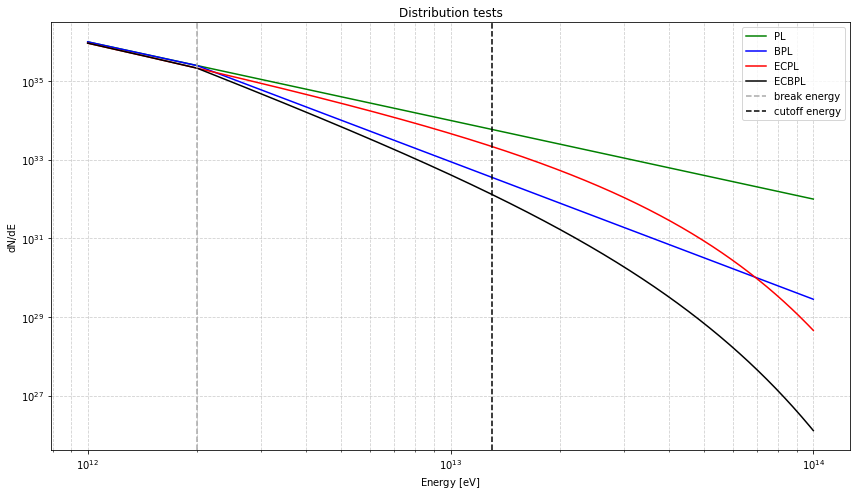

In [4]:
#energy_values = np.logspace(0.2, 0.7, 100) * u.TeV  # Da 0.1 a 100 TeV
energy_values = np.logspace(12,14,1000)*u.eV

flux1=PL(energy_values)
flux2=BPL(energy_values)
flux3=ECPL(energy_values)
flux4=ECBPL(energy_values)

plt.figure(figsize=[12,7])
plt.plot(energy_values,flux1,color="green",label="PL")
plt.plot(energy_values,flux2,color="blue",label="BPL")
plt.plot(energy_values,flux3,color="red",label="ECPL")
plt.plot(energy_values,flux4,color="black",label="ECBPL")

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy")
plt.axvline(e_cut.to(u.eV).value, color='black', linestyle='--', label="cutoff energy")
            
plt.xscale('log')
#plt.ylim(1e-2,1e0)
plt.yscale('log')
plt.legend()

plt.title( r'Distribution tests')
plt.xlabel('Energy [{0}]'.format(energy_values.unit.to_string('latex_inline')))
plt.ylabel('dN/dE')
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show



In [ ]:
plt.figure(figsize=[12,7])
plt.plot(energy_values,flux1,color="green",label="PL")
plt.plot(energy_values,flux2,color="blue",label="BPL")
plt.plot(energy_values,flux3,color="red",label="ECPL")
plt.plot(energy_values,flux4,color="black",label="ECBPL")

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy")
plt.axvline(e_cut.to(u.eV).value, color='black', linestyle='--', label="cutoff energy")
            
#plt.xscale('log')
#plt.ylim(1e-2,1e0)
plt.yscale('log')
plt.legend()

plt.title( r'Distribution tests')
plt.xlabel('Energy [{0}]'.format(energy_values.unit.to_string('latex_inline')))
plt.ylabel('dN/dE')
plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show

## Synchtron emission

In [5]:
import Radiative 

lunghezza_colori = 6

cmap1 = plt.cm.viridis  
colori1 = [cmap1(i) for i in np.linspace(0.3, 0.8, lunghezza_colori)]

cmap2= plt.cm.plasma
colori2 = [cmap2(i) for i in np.linspace(0.3, 0.8, lunghezza_colori)]

# Definiamo i parametri del modello
amplitude = 1e36 *u.Unit('1/eV')
e_0 = 1*u.TeV  # Energia di riferimento
alpha_1 = 2.1
alpha_2= 3.5

e_cut1=13*u.TeV
e_cut2=6*u.TeV

e_break=2.0*u.TeV
B_field=100*u.uG


PL = Models.PowerLaw(amplitude,e_0,alpha_1)
ECPL = Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut1)
ECPL2= Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut2)

SYN = Radiative.Synchrotron(PL, B=B_field)
SYN2= Radiative.Synchrotron(ECPL, B=B_field)
SYN3= Radiative.Synchrotron(ECPL2, B=B_field)

#Broken power
ECBPL1 = Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2,e_cutoff=e_cut1)
ECBPL2 = Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2,e_cutoff=e_cut2)


SYN4= Radiative.Synchrotron(ECBPL1, B=B_field)
SYN5= Radiative.Synchrotron(ECBPL2, B=B_field)

<function matplotlib.pyplot.show(*args, **kw)>

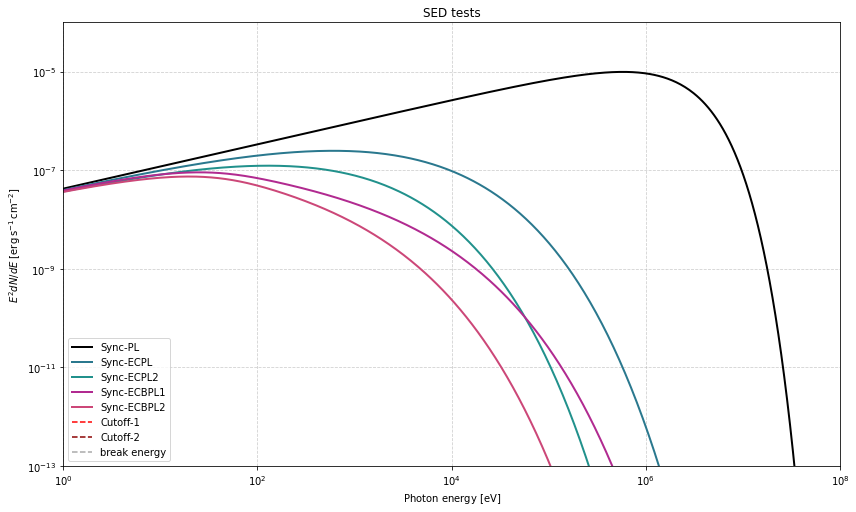

In [6]:

# Compute SEDs
spectrum_energy = np.logspace(-1,14,1000)*u.eV
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN2 = SYN2.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN3 = SYN3.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN4 = SYN4.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN5 = SYN5.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(12,7))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,sed_SYN2,lw=2,label='Sync-ECPL',c=colori1[1])
plt.loglog(spectrum_energy,sed_SYN3,lw=2,label='Sync-ECPL2',c=colori1[2])

plt.loglog(spectrum_energy,sed_SYN4,lw=2,label='Sync-ECBPL1',c=colori2[1])
plt.loglog(spectrum_energy,sed_SYN5,lw=2,label='Sync-ECBPL2',c=colori2[2])

plt.axvline(e_cut1.to(u.eV).value, color='red', linestyle='--', label="Cutoff-1") 
plt.axvline(e_cut2.to(u.eV).value, color='darkred', linestyle='--', label="Cutoff-2") 

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-13, 1e-4)
plt.xlim(1e0, 1e8)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests')

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [ ]:
# Plot
plt.figure(figsize=(12,7))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,sed_SYN2,lw=2,label='Sync-ECPL',c=colori1[1])
plt.loglog(spectrum_energy,sed_SYN3,lw=2,label='Sync-ECPL2',c=colori1[2])

plt.loglog(spectrum_energy,sed_SYN4,lw=2,label='Sync-ECBPL1',c=colori2[1])
plt.loglog(spectrum_energy,sed_SYN5,lw=2,label='Sync-ECBPL2',c=colori2[2])

plt.axvline(e_cut1.to(u.eV).value, color='red', linestyle='--', label="Cutoff-1") 
plt.axvline(e_cut2.to(u.eV).value, color='darkred', linestyle='--', label="Cutoff-2") 

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_SYN.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-13, 1e-4)
plt.xlim(1e1, 1e14)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests',fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [ ]:
# Compute fluxs
spectrum_energy = np.logspace(-1,14,1000)*u.eV
dist=1.5*u.kpc

flux_SYN = SYN.flux(spectrum_energy, distance=dist)
flux_SYN2 = SYN2.flux(spectrum_energy, distance=dist)
flux_SYN3 = SYN3.flux(spectrum_energy, distance=dist)
flux_SYN4 = SYN4.flux(spectrum_energy, distance=dist)
flux_SYN5 = SYN5.flux(spectrum_energy, distance=dist)


# Plot
plt.figure(figsize=(12,7))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,flux_SYN,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,flux_SYN2,lw=2,label='Sync-ECPL',c=colori1[1])
plt.loglog(spectrum_energy,flux_SYN3,lw=2,label='Sync-ECPL2',c=colori1[2])

plt.loglog(spectrum_energy,flux_SYN4,lw=2,label='Sync-ECBPL1',c=colori2[1])
plt.loglog(spectrum_energy,flux_SYN5,lw=2,label='Sync-ECBPL2',c=colori2[2])

#plt.axvline(e_cut1.value, color='red', linestyle='--', label="Cutoff-1") 
#plt.axvline(e_cut2.value, color='darkred', linestyle='--', label="Cutoff-2") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$Flux$ [{0}]'.format(flux_SYN.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-13, 1e8)
plt.xlim(1e0, 1e8)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title(f"Flux test for distance={dist}",fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [ ]:
# Compute fluxs
spectrum_energy = np.logspace(-1,14,1000)*u.eV
dist=50*u.Mpc

flux_SYN = SYN.flux(spectrum_energy, distance=dist)
flux_SYN2 = SYN2.flux(spectrum_energy, distance=dist)
flux_SYN3 = SYN3.flux(spectrum_energy, distance=dist)
flux_SYN4 = SYN4.flux(spectrum_energy, distance=dist)
flux_SYN5 = SYN5.flux(spectrum_energy, distance=dist)


# Plot
plt.figure(figsize=(12,7))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,flux_SYN,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,flux_SYN2,lw=2,label='Sync-ECPL',c=colori1[1])
plt.loglog(spectrum_energy,flux_SYN3,lw=2,label='Sync-ECPL2',c=colori1[2])

plt.loglog(spectrum_energy,flux_SYN4,lw=2,label='Sync-ECBPL1',c=colori2[1])
plt.loglog(spectrum_energy,flux_SYN5,lw=2,label='Sync-ECBPL2',c=colori2[2])


#plt.axvline(e_cut1.value, color='red', linestyle='--', label="Cutoff-1") 
#plt.axvline(e_cut2.value, color='darkred', linestyle='--', label="Cutoff-2") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$Flux$ [{0}]'.format(flux_SYN.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-13, 1e-4)
plt.xlim(1e0, 1e8)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title(f"Flux test for distance={dist}",fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

## Inverse Compton emission

In [8]:
# Definiamo i parametri del modello
amplitude = 1e36 *u.Unit('1/eV')
e_0 = 1*u.TeV  # Energia di riferimento
alpha_1 = 2.1
alpha_2= 3.5

e_cut1=13*u.TeV
e_cut2=6*u.TeV

e_break=2.0*u.TeV
B_field=100*u.uG

#--------------------- A string equal to radiation fields: --------------------------------------------------------------------#
#                                                                                                                              #
#      "CMB" (default, Cosmic Microwave Background),2.72 K, energy densitiy of 0.261 eV/cm³                                    #
#      "NIR" (Near Infrared Radiation),  30 K, energy densitiy 0.5 eV/cm³                                                      #
#      "FIR" (Far Infrared Radiation), 3000 K,energy densitiy 1 eV/cm³                                                         #
#                                                                                                                              #
#      "mode NIR" ['NIR', 50 * u.K, 1.5 * u.eV / u.cm**3].                                                                     #
#      "hot, bright star at 120 degrees to the line-of-sight": ['star', 25000 * u.K, 3 * u.erg / u.cm**3, 120 * u.deg].        #
#      "emitter with spectral index 2 between 1 and 10 keV": ['X-ray', [1, 10] * u.keV, [1, 1e-2] * 1 / (u.eV * u.cm**3)].     #
#      "monochromatic photon field at 50 eV": ['UV', 50 * u.eV, 15 * u.eV / u.cm**3].                                          #
#                                                                                                                              #
#------------------------------------------------------------------------------------------------------------------------------#

PL = Models.PowerLaw(amplitude,e_0,alpha_1)
ECPL = Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut1)
ECPL2= Models.ExponentialCutoffPowerLaw(amplitude, e_0, alpha_1, e_cut2)

IC=Radiative.InverseCompton(PL, seed_photon_fields=['CMB', 'FIR', 'NIR'])
IC2=Radiative.InverseCompton(ECPL,  seed_photon_fields=['CMB', 'FIR', 'NIR'])
IC3=Radiative.InverseCompton(ECPL2,  seed_photon_fields=['CMB', 'FIR', 'NIR'])

#Broken power
ECBPL1 = Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2,e_cutoff=e_cut1)
ECBPL2 = Models.ExponentialCutoffBrokenPowerLaw(amplitude, e_0, e_break,alpha_1,alpha_2,e_cutoff=e_cut2)


IC4=Radiative.InverseCompton(ECBPL1, seed_photon_fields=['CMB', 'FIR', 'NIR'])
IC5=Radiative.InverseCompton(ECBPL2, seed_photon_fields=['CMB', 'FIR', 'NIR'])

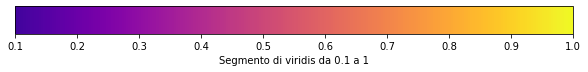

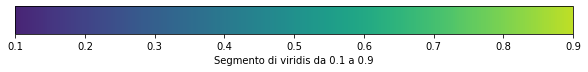

In [9]:

from matplotlib import cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.colorbar import ColorbarBase

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

vmin = 0.1
vmax = 1
original_cmap = plt.cm.plasma

cmap1 = truncate_colormap(original_cmap, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap1,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()

vmin = 0.1
vmax = 0.9
original_cmap2 = plt.cm.viridis

cmap2 = truncate_colormap(original_cmap2, vmin, vmax)
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
norm = Normalize(vmin, vmax)  # da 0 a 1 perché stai solo mostrando il segmento
cb = ColorbarBase(ax,cmap=cmap2,norm=norm,orientation='horizontal')
cb.set_label(f'Segmento di viridis da {vmin} a {vmax}')
plt.show()



<function matplotlib.pyplot.show(*args, **kw)>

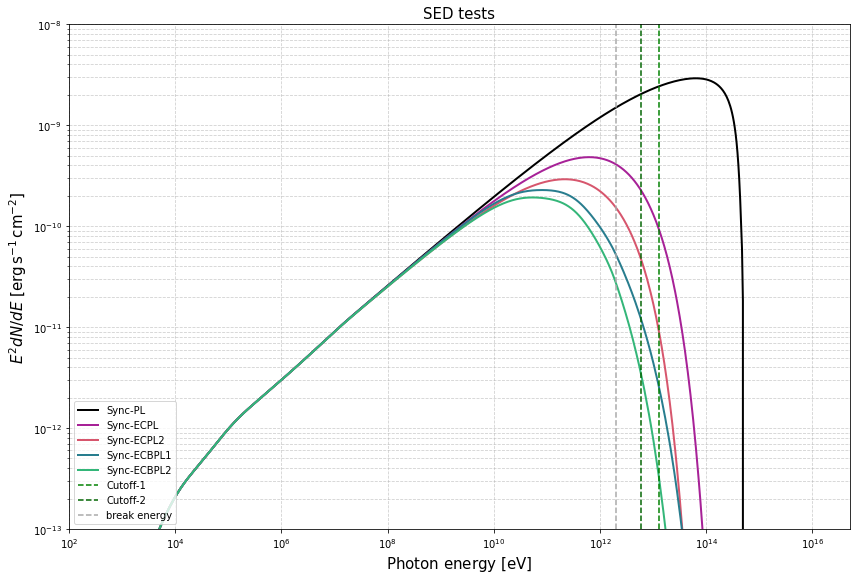

In [10]:

# Compute SEDs
spectrum_energy = np.logspace(-1,16,1000)*u.eV
sed_IC = IC.sed(spectrum_energy,distance=1.5*u.kpc)
sed_IC2 = IC2.sed(spectrum_energy, distance=1.5*u.kpc)
sed_IC3 = IC3.sed(spectrum_energy, distance=1.5*u.kpc)
sed_IC4 = IC4.sed(spectrum_energy, distance=1.5*u.kpc)
sed_IC5 = IC5.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(12,8))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_IC,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,sed_IC2,lw=2,label='Sync-ECPL',c=cmap1(0.3))
plt.loglog(spectrum_energy,sed_IC3,lw=2,label='Sync-ECPL2',c=cmap1(0.5))

plt.loglog(spectrum_energy,sed_IC4,lw=2,label='Sync-ECBPL1',c=cmap2(0.4))
plt.loglog(spectrum_energy,sed_IC5,lw=2,label='Sync-ECBPL2',c=cmap2(0.7))

plt.axvline(e_cut1.to(u.eV).value, color='green', linestyle='--', label="Cutoff-1") 
plt.axvline(e_cut2.to(u.eV).value, color='darkgreen', linestyle='--', label="Cutoff-2") 

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_IC.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-13, 1e-8)
plt.xlim(1e2, 5e16)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests',fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [ ]:
# Compute SEDs
spectrum_energy = np.logspace(-1,16,1000)*u.eV

sed_IC = IC.sed(spectrum_energy,distance=1.5*u.kpc)
sed_IC1= IC.sed(spectrum_energy,seed='CMB',distance=1.5*u.kpc)
sed_IC2= IC.sed(spectrum_energy,seed='FIR',distance=1.5*u.kpc)
sed_IC3= IC.sed(spectrum_energy,seed='NIR',distance=1.5*u.kpc)

sed_IC2 = IC2.sed(spectrum_energy, distance=1.5*u.kpc)
sed_IC21 = IC2.sed(spectrum_energy,seed='CMB',distance=1.5*u.kpc)
sed_IC22= IC2.sed(spectrum_energy,seed='FIR',distance=1.5*u.kpc)
sed_IC23 = IC2.sed(spectrum_energy,seed='NIR',distance=1.5*u.kpc)


# Plot
plt.figure(figsize=(12,8))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_IC,lw=2,label='Sync-PL',c="black")
plt.loglog(spectrum_energy,sed_IC1,lw=2,label='Sync-PL-CMB',c=cmap1(0.4))
plt.loglog(spectrum_energy,sed_IC2,lw=2,label='Sync-PL-FIR',c=cmap1(0.6))
plt.loglog(spectrum_energy,sed_IC3,lw=2,label='Sync-PL-NIR',c=cmap1(0.8))

plt.loglog(spectrum_energy,sed_IC2,lw=2,label='Sync-ECPL',c="black")
plt.loglog(spectrum_energy,sed_IC21,lw=2,label='Sync-ECPL-CMB',c=cmap2(0.4))
plt.loglog(spectrum_energy,sed_IC22,lw=2,label='Sync-ECPL-FIR',c=cmap2(0.6))
plt.loglog(spectrum_energy,sed_IC23,lw=2,label='Sync-ECPL-NIR',c=cmap2(0.8))


 
plt.axvline(e_cut2.to(u.eV).value, color='darkgreen', linestyle='--', label="Cutoff-2") 

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_IC.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-12, 1e-8)
plt.xlim(1e2, 5e16)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests',fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [ ]:
# Compute SEDs
spectrum_energy = np.logspace(-1,16,1000)*u.eV

sed_IC2 = IC4.sed(spectrum_energy, distance=1.5*u.kpc)
sed_IC21 = IC4.sed(spectrum_energy,seed='CMB',distance=1.5*u.kpc)
sed_IC22= IC4.sed(spectrum_energy,seed='FIR',distance=1.5*u.kpc)
sed_IC23 = IC4.sed(spectrum_energy,seed='NIR',distance=1.5*u.kpc)


# Plot
plt.figure(figsize=(12,8))
#plt.rc('font', family='sans')
#plt.rc('mathtext', fontset='custom')

plt.loglog(spectrum_energy,sed_IC,lw=2,label='Sync-ECBPL1',c="black")
plt.loglog(spectrum_energy,sed_IC1,lw=2,label='Sync-ECBPL1-CMB',c=cmap1(0.4))
plt.loglog(spectrum_energy,sed_IC2,lw=2,label='Sync-ECBPL1-FIR',c=cmap1(0.6))
plt.loglog(spectrum_energy,sed_IC3,lw=2,label='Sync-ECBPL1-NIR',c=cmap1(0.8))


 
plt.axvline(e_cut1.to(u.eV).value, color='darkgreen', linestyle='--', label="Cutoff-1") 

plt.axvline(e_break.to(u.eV).value, color='darkgray', linestyle='--', label="break energy") 

plt.xlabel('Photon energy [{0}]'.format(spectrum_energy.unit.to_string('latex_inline')),fontsize=15)
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(sed_IC.unit.to_string('latex_inline')),fontsize=15)
plt.ylim(1e-12, 1e-8)
plt.xlim(1e2, 5e16)
plt.tight_layout()
plt.legend(loc='lower left')
plt.legend(loc='lower left')


plt.title( r'SED tests',fontsize=15)

plt.grid(True, which="both", linestyle="--", alpha=0.6)
plt.show

In [27]:
spectrum_energy = np.logspace(-1,16,1000)*u.eV

Lsy = SYN.flux(spectrum_energy, distance=0*u.cm)
R = 2 * u.pc
phn_sy = Lsy / (4 * np.pi * R.to(u.cm)**2 * c) * 2.24 


#validate_physical_type("phn_sy", Lsy, "differential number density")
print(phn_sy.unit)

1 / (cm2 eV m)


In [28]:

spectrum_energy = np.logspace(-1,16,1000)*u.eV

Lsy = SYN.flux(spectrum_energy, distance=0*u.cm)

# Define source radius and compute photon density
R = 2 * u.pc
phn_sy = Lsy / (4 * np.pi * R**2 * c) * 2.24 
SSC_seed=['SSC', spectrum_energy, phn_sy]

# Create IC instance with CMB and synchrotron seed photon fields:
IC = Radiative.InverseCompton(ECBPL1, seed_photon_fields=['CMB', 'FIR', 'NIR',['SSC', spectrum_energy, phn_sy]])

# Compute SEDs
sed_IC = IC.sed(spectrum_energy, distance=1.5*u.kpc)
sed_SYN = SYN.sed(spectrum_energy, distance=1.5*u.kpc)

# Plot
plt.figure(figsize=(12,8))

plt.rc('font', family='sans')
plt.rc('mathtext', fontset='custom')
ssc = IC.sed(spectrum_energy, seed='SSC', distance=1.5*u.kpc)

plt.loglog(spectrum_energy,ssc,lw=1.5,
        ls='-',label='IC (SSC)',c=cmap1[0.4])

for seed, ls in zip(['CMB','FIR','NIR'], ['-','--',':']):
    sed = IC.sed(spectrum_energy, seed=seed, distance=1.5*u.kpc)
    plt.loglog(spectrum_energy,sed,lw=1,
            ls=ls,c='0.25')#,label='IC ({0})'.format(seed))

plt.loglog(spectrum_energy,sed_IC,lw=2,
        label='IC (total)',c=cmap1(0.6))

plt.loglog(spectrum_energy,sed_SYN,lw=2,label='Sync',c=cmap2(0,9))

plt.xlabel('Photon energy [{0}]'.format(
        spectrum_energy.unit.to_string('latex_inline')))
plt.ylabel('$E^2 dN/dE$ [{0}]'.format(
        sed_SYN.unit.to_string('latex_inline')))
plt.ylim(1e-12, 1e-6)
plt.tight_layout()
plt.legend(loc='lower left')

TypeError: SSC-density should be given in units of differential number density